## Visualizing results of the Second Edition -  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the books of the **Seond Edition ** of the Encyclopaedia Britannica. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_second_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_second_edition -n 16`

The nls_first_edition.txt has the path of this particular book that we are exploring:

`/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850370
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850373
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850374
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850375
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850376
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850377
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850378
/home/tdm/datasets/nls-data-encyclopaediaBritannica/144850379
/home/tdm/datasets/nls-data-encyclopaediaBritannica/190273289
/home/tdm/datasets/nls-data-encyclopaediaBritannica/190273290`

And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

The results file ( [eoresolution_en_core_web_lg_EB_first_edition](http://localhost:8888/edit/results_NLS/georesolution_en_core_web_lg_EB_second_edition) ) is stored in this repository under the *results_NLS* subdirectory. 

Note: We just perfomed this study using all the pages of one boo. But we could run this query using the full EB dataset.


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def display_spacy_entities(result):
    for i in result.keys():
        for k in result[i]:
            html= k["display_doc"]
            if html:
                print(" \n ----- %s: Entities with the Spacy \"%s\" language model  ----- \n" % (k["text_unit id"], k["lang_model"]))
                display(HTML(html))

In [4]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [5]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [6]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [7]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq)
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned')
    plt.show()

### Information about the defoe georesolution query

This query does the following tasks:

- Ingests all the pages from all the books of the first edition
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * display_doc: HTML string with the name entities detected by spacy for each page
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (e.g. en_core_web_lg)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


In [8]:
results=read_query_results('georesolution_en_core_web_lg_EB_second_edition')

In [9]:
#display_spacy_entities(results)

In [10]:
df_total= geresolution_dataframe(results)

In [11]:
df_total.head(10)

,Latitude,Longitude,Place,Page
0,43.00813,-74.78932,Danube,Page32
1,31.5,34.75,Israel,Page32
2,59.32938,18.06871,Stockholm,Page32
3,51.5,10.5,Germany,Page32
4,45.50032,-69.24977,Maine,Page32
5,64,26,Finland,Page32
6,38.23811,-86.7336,Siberia,Page32
7,62,15,Sweden,Page32
8,60.43306,22.23306,Aurajoki,Page32
9,60,100,Russia,Page32


In [12]:
df_total[["Place"]].count()

Place    6298
dtype: int64

In [13]:
df_total.sum()

Latitude     43.0081331.559.3293851.545.500326438.238116260...
Longitude    -74.7893234.7518.0687110.5-69.2497726-86.73361...
Place        DanubeIsraelStockholmGermanyMaineFinlandSiberi...
Page         Page32Page32Page32Page32Page32Page32Page32Page...
dtype: object

In [14]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
AUSTRIA,1,1,1
Aberdeen,2,2,2
Abingdon,1,1,1
Abington,1,1,1
Abruzzo,1,1,1
Abyssinia,1,1,1
Acapulco,4,4,4
Achaia,2,2,2
Ackworth,1,1,1


In [15]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page1001,5,5,5
Page1003,16,16,16
Page1004,17,17,17
Page1005,34,34,34
Page1007,40,40,40
Page1008,16,16,16
Page1136,10,10,10
Page1137,1,1,1
Page1138,1,1,1


In [16]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude  Longitude              
-0.24849  35.73194        1     1
-0.25     -79.13333       1     1
-1        15.5            1     1
-10       -55             9     9
          -75.25          9     9
-10.10883 17.97834        1     1
-10.18333 149.86667       1     1
-12.04318 -77.02824       5     5
-12.3885  130.88088       1     1
-12.5     18.5            3     3
-13       -56             1     1
-13.45    33.15           1     1
-13.65    33.51667        2     2
-14.60485 -57.65625       7     7
-15.1     -73.76667       1     1
-15.15    31.45           1     1
-15.36194 38.70139        1     1
-16.32389 35.94028        1     1
-17.04035 26.55098        1     1
-17.78271 31.33127        1     1
-18.01667 27.13333        1     1
-18.02203 30.97533        1     1
-18.25    35              1     1
-18.31667 30.31667        1     1
-18.91299 125.52527       1     1
-19.36667 29.68333        1     1
          29.78333        1     1
-19.38333 29.71667        1     1
-2.13154  120.28888       1     1
-2.64238  26.54853        1     1
...                     ...   ...
60.43306  22.23306        1     1
60.56595  5.01537         1     1
60.8616   49.7948         1     1
61.0308   49.9138         1     1
61.1433   54.36585        1     1
61.21806  -149.90028      1     1
61.63333  17.18333        1     1
61.83333  15.71667        2     2
62        10             21    21
          15             47    47
63.46704  11.49757        1     1
63.76333  98.05917        2     2
64        26              6     6
64.06013  -139.43328      1     1
64.53176  40.49389        1     1
64.75     -21.83333       1     1
65        -15             2     2
          -18            47    47
66.03333  -91.83333       1     1
66.8      24              1     1
68.50472  112.4485        1     1
7.1881    21.09375       58    58
7.75      80.75           1     1
71.98002  102.47111       3     3
9         -80             4     4
          39.5            6     6
9.31667   -82.16667       3     3
9.35322   -10.88623       1     1
9.5       2.25            1     1
9.93988   76.26022        1     1

[1649 rows x 2 columns]

In [17]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

# removing the first forw
df_max_geolocations=df_filter
#df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(15)

,Latitude,Longitude,count
1432,52.16045,-0.70312,318
394,34.23314,-102.41075,242
1568,56,-4,209
1156,46,2,185
1360,51.50853,-0.12574,144
722,40,-4,121
1241,48.69096,9.14062,113
892,41.89193,12.51133,101
983,42.83333,12.83333,97
1414,52,20,89


In [18]:
#place_count, place_name= get_place(df_total, '50.6522111706725', '-3.615645583175173')


In [22]:
#Getting the 15 places (and their frequencies) most mentioned - filtering out some elements
filter_list=['earth']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)

0 318 England
2 209 Scotland
3 185 France
4 144 London
5 121 Spain
6 113 Europe
7 101 Rome
8 97 Italy
9 89 Poland
10 87 Glasgow
11 80 Germany
12 78 Britain
13 72 China
14 70 Paris
15 67 Edinburgh


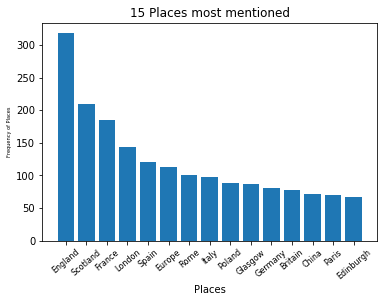

In [20]:
#Visualizing the 15 places in a Bar plot
plot_bar_places(place_label, place_freq)